In [12]:
import re
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
def split_data(
    df: pd.DataFrame,
    label_col: str = 'label',
    test_size: float = 0.3,
    random_state: int = None
) -> tuple[pd.DataFrame]:

    def ensure_all_labels(original_df, train_df, test_df, label_col):
        original_labels = set(original_df[label_col])
        train_labels = set(train_df[label_col])
        missing_labels = original_labels - train_labels

        if missing_labels:
            for label in missing_labels:
                missing_sample = test_df[test_df[label_col] == label].sample(n=1)
                test_df = test_df[~(test_df[label_col].isin(missing_sample.labels))]
                train_df = pd.concat([train_df, missing_sample])
        return train_df, test_df

    try:
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            stratify=df[label_col],
            random_state=random_state
        )

        train_df, test_df = ensure_all_labels(df, train_df, test_df, label_col)

    except ValueError as e:
        warnings.warn(
            f"{e} --- Falling back to random split. Consider reviewing extremely small classes."
        )

        # Fallback to random split if stratified split fails
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state
        )

        train_df, test_df = ensure_all_labels(df, train_df, test_df, label_col)

    return train_df, test_df

In [3]:
def remove_emojis(text):
    """
    Remove emojis from the text.

    Args:
        text (str): The input text from which emojis will be removed.

    Returns:
        str: The text without emojis and extra spaces.
    """
    return emoji.replace_emoji(text, replace='').replace("  ", " ")

In [4]:
def contains_countdown(text):
    """
    Determine if the text contains a countdown message.

    Args:
        text (str): The input text to analyze.

    Returns:
        bool: True if the text contains a countdown message, False otherwise.
    """
    text = remove_emojis(text)
    
    if re.search(r'delayed|post(-)?pone(d)?|cancel(l)?ed|resched(u)?l(l)?ed', text, re.IGNORECASE):
        return False
    
    countdown_regex_1 = (
        r'\b(\d+\s*)?\s*'
        r'(hour(s)?|day(s)?|mi(n|m)ute(s)?|min(s|t|ts)?|sec(s)?|second(s)?)'
        r'\s*(left|remaining|to go|(more )?un(t)?il|before|on|(be|get)\s*ready|for)\b'
    )

    countdown_regex_2 = (
        r'\b\d+\s*(minute(s)?|min(s|t|ts)?|hour(s)?)\s*(be|get)\s*ready\b'
    )

    countdown_regex_3 = (
        r'\bpump\s+on\s+([\w_]+)?\s*(will\s+be|is)\s+in\s*(exact(ly|ely|lely))?\s*(\d+)\s*(hour(s)?|minute(s)?|second(s)?|day(s)?)\b'
    )

    countdown_regex_4 = (
        r'\bpump\s+day\b'
    )

    countdown_regex_5 = (
        r'\b\d+\s*(minute(s)?|hour(s)?)\s*more\s*left\s*for\s*pum(p)?\b'
    )
    
    countdown_regex_6 = (
        r'\bpump\s+is\s+in\s+(\d+)\s*(hour(s)?|minute(s)?|second(s)?|day(s)?)\b'
    )

    if (
        re.search(countdown_regex_1, text, re.IGNORECASE) or
        re.search(countdown_regex_2, text, re.IGNORECASE) or
        re.search(countdown_regex_3, text, re.IGNORECASE) or
        re.search(countdown_regex_4, text, re.IGNORECASE) or
        re.search(countdown_regex_5, text, re.IGNORECASE) or
        re.search(countdown_regex_6, text, re.IGNORECASE)
    ):
        return True

    if re.search(r'\bcount(-)?down\b', text, re.IGNORECASE):
        return True

    return False

In [5]:
def contains_pump_announcement(text):
    """
    Determine if the text contains a pump announcement.

    Args:
        text (str): The input text to analyze.

    Returns:
        bool: True if the text contains a pump announcement, False otherwise.
    """
    text = remove_emojis(text)
    
    if re.search(r'delayed|post(-)?pone(d)?|cancel(l)?ed|resched(u)?l(l)?e(d)?|pump\s+is\s+late|technical problem(s)?|pump\s+(change(d)?|move(d)?)', text, re.IGNORECASE):
        return False

    if re.search(r'pump result(s)?|result(s)?', text, re.IGNORECASE):
        return False
    
    exchanges = (
        r'xt(_cex)?|kucoin(_cex)?|binance(_cex)?|mexc(_cex)?|poloniex(_cex)?|gate(_cex)?|bittrex(_cex)?|'
        r'latoken(_cex)?|bitfinex(_cex)?|huobi(_cex)?|ftx(_cex)?|kraken(_cex)?|bybit(_cex)?|okex(_cex)?|'
        r'crypto\.com(_cex)?|bitmex(_cex)?|coinbase(_cex)?|bitstamp(_cex)?|lbank(_cex)?|pancakeswap(_dex)?|'
        r'hotbit(_cex)?|vindax(_cex)?|Pancake(swap)?(_dex)?|digifinex(_cex)?|l(_)?bank(_cex)?|cryptopia_(cex)?|'
        r'raydium(_dex)?'
    )

    date_regex = (
        r'('
        r'(\b(sunday|monday|tuesday|wednesday|thursday|friday|saturday|today|tomorrow)\b\s*,?\s*)?'
        r'('
        r'(\b(january|february|march|april|may|june|july|august|september|october|november|december|jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b\s*,?\s*\d{1,2}(st|nd|rd|th|h)?(?:\s*,?\s*\d{4})?)'
        r'|'
        r'(\d{1,2}(st|nd|rd|th|h)?\s*,?\s*\b(january|february|march|april|may|june|july|august|september|october|november|december|jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b(?:\s*,?\s*\d{4})?)'
        r'|' 
        r'(\d{1,2}(st|nd|rd|th|h)?(january|february|march|april|may|june|july|august|september|october|november|december))'
        r'|' 
        r'(\d{1,2}(st|nd|rd|th|h)?\s+\b(january|february|march|april|may|june|july|august|september|october|november|december)\b\s+(sunday|monday|tuesday|wednesday|thursday|friday|saturday))'
        r'|' 
        r'\b(today|tomorrow)\b'
        r'|' 
        r'\d{1,2}\s+(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b'
        r')'
        r')'
    )

    pump_announcement_regex_1 = (
        r'\b(pump\s+announc(e)?ment|major\s+pump|our\s+next\s+pump|official\s+pump|pump\s+signal|big\s+pump|'
        r'upcoming\s+pump|\s+event|pump\s+update|this\s+[a-z]+\s*night|pump\s+alert|signal\s+announcement|crypto\s+pump\s+announc(e)?ment)\b'
    )
    
    exchange_regex = fr'\b({exchanges})\b'

    if re.search(exchange_regex, text, re.IGNORECASE):
        if re.search(date_regex, text, re.IGNORECASE):
            if re.search(pump_announcement_regex_1, text, re.IGNORECASE):
                return True
                
    return False

In [6]:
def contains_delay_cancellation_announcement(text):
    """
    Determine if the text contains a delay or cancellation announcement for a pump.

    Args:
        text (str): The input text to analyze.

    Returns:
        bool: True if the text contains a delay or cancellation announcement, False otherwise.
    """
    text = remove_emojis(text)

    delay_keywords_regex = (
        r'delayed|post(-)?pon(e)?(d|ing)?|cancel(l)?ed|resched(u)?l(l)?e(d)?|pump\s+is\s+late|technical problem(s)?|pump\s+(change(d)?|move(d)?)'
    )
    
    pump_late_regex = (
        r'\bpump\s+(is|was|will\s+be)\s+'
        r'(\d+|a\s+few|several|[a-z]+)\s*'  # Matches "10", "a few", "several", or "ten"
        r'(minute(s)?|min(s)?|hour(s)?|hr(s)?|day(s)?|second(s)?|sec(s)?)\s+'
        r'late\b'
    )

    if re.search(delay_keywords_regex, text, re.IGNORECASE) or re.search(pump_late_regex, text, re.IGNORECASE):
        return True
    
    return False

In [7]:
def contains_pump_result(text):
    """
    Determine if the text contains pump result information.

    Args:
        text (str): The input text to analyze.

    Returns:
        bool: True if the text contains pump result information, False otherwise.
    """
    text = remove_emojis(text)

    exclusion_regex = (
        r'\b('
        r'limited\s+offer|special\s+offer|keep\s+buying'
        r'\d+(\.\d+)?\s*%\s+already\s+done|'
        r'\d+(\.\d+)?\s*%\s+done|'
        r'buy\s+now|join\s+our\s+vip|exclusive\s+event|keep buy(ing)?|best signals for our vip member(s|ship|ships)|'
        r'\b(\d+\s*spots\s+left\s+for\s+\d+(\.\d+)?\s*%\s*discount\s+in\s+the\s+vip\s+group(\s+before\s+the\s+next\s+pump)?|[a-z]+\s+spots\s+left\s+for\s+\d+(\.\d+)?\s*%\s*discount\s+in\s+the\s+vip\s+group(\s+before\s+the\s+next\s+pump)?|'
        r'token\s+website|referral\s+program|\d+\s*people\s+selected\s+done|rules\s+of\s+a\s+successful\s+pump)\b|'
        r'\battention\b.*\bafter\s+the\s+impressive\s+last\s+pumps\s+we\s+had\b'
        r')\b'
    )

    if re.search(exclusion_regex, text, re.IGNORECASE):
        return False
    
    pump_result_regex = (
        r'\b('
        r'pump\s+result(s)?|official\s+result(s)?|'
        r'results\s+one\s+of\s+our\s+vip\s+membership|'
        r'budget\s*\(.*?\)\s*\d+k?\s*\$\s+in\s*\d+k?\s*\$|'
        r'final\s+price|earnings\s+on\s+top|congratulations\s+everyone|'
        r'successful\s+pump|peak\s+gain|profit\s+in\s+minutes|'
        r'gain\s+over|done|break\s+record|new\s+record|'
        r'(?:\d+(\.\d+)?\s*%|x)\s*(profit|gain)|'
        r'start\s+price\s+-?\s*\$?\d+(\.\d+)?|peak\s+price\s+-?\s*\$?\d+(\.\d+)?|'
        r'low\s*:\s*\$?\d+(\.\d+)?|high\s*:\s*\$?\d+(\.\d+)?|final\s+price\s*:\s*\$?\d+(\.\d+)?|'
        r'\d+(\.\d+)?\s*%\s+pump|our\s+last\s+amazing\s+pumping|'
        r'we\s+just\s+pumped\s+\d+(\.\d+)?\s*%|'
        r'the\s+peak\s+was\s+at\s+over\s+\d+(\.\d+)?\s*%|'
        r'volume\s+on\s+our\s+\d+(\.\d+)?\s*pump\s+was\s+\d+(\.\d+)?|'
        r'we\s+managed\s+to\s+achieve\s+a\s+\d+(\.\d+)?\s*%\s+percentage\s+gain|'
        r'\d+(\.\d+)?\s*%\s+absolutely\s+remarkable|'
        r'\$\s*[A-Z]+.*\+\s*\d+(\.\d+)?\s*%|'
        r'\d+(\.\d+)?\s*x\s*(profit|gain)|'
        r'we\s+had\s+a\s+\d+x\s+on\s+[A-Za-z]+\s*'
        r')\b'
    )

    if re.search(pump_result_regex, text, re.IGNORECASE):
        return True

    return False

In [8]:
def contains_coin_release(text):
    """
    Determine if the text contains a coin release announcement.

    Args:
        text (str): The input text to analyze.

    Returns:
        bool: True if the text contains a coin release announcement, False otherwise.
    """
    text = remove_emojis(text)
    
    early_exclusion_regex = (
        r'\b('
        r'presale|airdrop|staking|whitelist|IDO|minting|NFT|'
        r'giveaway|public\s+sale|locked\s+liquidity|roadmap|'
        r'tokenomics|vesting|distribution|whitepaper'
        r')\b'
    )
    
    if re.search(early_exclusion_regex, text, re.IGNORECASE):
        return False
    
    obvious_coin_release_regex = (
        r'\b(the\s+)?coin\s+we\s+are\s+pumping\s+(today\s+)?is\b|'
        r'selected\s+(coin|token)\b|'                               
        r'\b(coin|token)\s+is\b|'                                   
        r'chosen\s+(coin|token)\s+for\s+the\s+upcoming\s+pump\b|'    
        r'let\'?s\s+pump\s*[:;]?\s*\$?\s*[A-Za-z0-9]{2,7}\b|'        
        r'pump\s+target\s+(for\s+today\s+)?is\b|'                   
        r'our\s+pump\s+signal\s+is\s+on\b|'                         
        r'today\'?s\s+pump\s*,?\s+we\'?re\s+going\s+with\b|'        
        r'we\'?ve\s+chosen\s*\$?[A-Za-z]{2,7}\s+for\s+the\s+pump\b|' 
        r'the\s+coin\s+we\s+have\s+picked\s+to\s+pump\s+today\s*[:\-]?\s*\$?[A-Za-z]{2,7}\b|' 
        r'the\s+coin\s+we\s+will\s+pump\s+is\b|'                     
        r'[A-Za-z0-9]{2,7}\s+has\s+been\s+chosen\s+as\s+the\s+coin\b|' 
        r'we\'?ve\s+picked\s+[A-Za-z0-9]{2,7}\s+for\s+our\s+next\s+pump\b|'  
        r'the\s+coin\s+we\s+are\s+pumping\s+tonight\s+is\b|'          
        r'\bTHE\s+COIN\s+SELECTED\s+IS\s+\$?\s*[A-Za-z0-9]{2,7}\b|'   
        r'\bSTART\s+BUYING\s+\$?[A-Za-z0-9]{2,7}\s*!+\b|'            
        r'we\'?ve\s+chosen\s*\$?[A-Za-z0-9]{2,7}\s+for\s+the\s+pump\b|'
        r'our\s+[A-Za-z]+_CEX\s+(Ultra\s+)?Signal\s+today\s*[:\-]?\s*\$?[A-Za-z0-9]{2,7}\s+Buy\s+and\s+hold\s+for\s+massive\s+profits\s+EXCHANGE:\s*[A-Za-z]+_CEX\s*;\s*trading\s+pair\s*[:\-]?\s*\$?[A-Za-z0-9]{2,7}(\s*[-_/]\s*)?USD(T)?\b'  # "Our Binance_CEX Ultra Signal Today is : WAN Buy and hold for massive profits EXCHANGE: binance_CEX; TRADING PAIR: WAN-USDT"
    )

    if re.search(obvious_coin_release_regex, text, re.IGNORECASE):
        return True

    if len(text) <= 15 and re.search(r'/\s+USD(T)?', text, re.IGNORECASE):
        return True

    exclusion_regex = (
        r'\b('
        r'limited\s+offer|special\s+offer|keep\s+buying|buy\s+now|join\s+our\s+vip|'
        r'exclusive\s+event|best\s+signals\s+for\s+our\s+vip\s+member(s|ship|ships)|'
        r'\d+\s*spots\s+left\s+for\s+\d+(\.\d+)?\s*%\s*discount\s+in\s+the\s+vip\s+group(\s+before\s+the\s+next\s+pump)?|'
        r'\d+\s*people\s+selected\s+done|rules\s+of\s+a\s+successful\s+pump|'
        r'token\s+website|referral\s+program|attention.*after\s+the\s+impressive\s+last\s+pumps\s+we\s+had\b|'
        r'steps\s+you\s+need\s+to\s+follow|sign\s+up|deposit|how\s+to\s+join|VIP\s+members|public\s+presale|airdrop(s)?|private\s+sale(s)?'
        r'giveaway|congrats\s+everyone|profits|results|successful|join\s+our\s+pump|join\s+vip|'
        r'listing\s+soon|staking\s+coming\s+soon|missed\s+(Bonk|Pepe|etc)|\bNFT\b|KYC\b|presale\s+just\s+started|'
        r'sending\s+coin\s+name|contact\s+@user|congrats\s+everyone|profits|results|successful|join\s+our\s+pump|join\s+vip|'
        r'start\s+sel(l)?(ing)?|stop\s+buy(ing|ng|ying)?|airdrop(s)?|smart\s+contract\s+renounced\b|liquidity\s+locked\b|telegram\s+group\b|'
        r'(boom|wow)'
        r')\b'
    )
        
    max_length_for_coin_release = 150
    
    if re.search(exclusion_regex, text, re.IGNORECASE) or len(text) > max_length_for_coin_release:
        return False
    
    coin_release_regex = (
        r'\b('
        r'for\s+today\'?s\s+pump\s*,?\s+we\'?re\s+going\s+with\s+\$?[A-Z]{2,6}|'  
        r'coin\s+is\s*[:\-]?\s*\$?[A-Z]{2,6}|'                                   
        r'the\s+coin\s+we\s+are\s+pumping\s+today\s*[:\-]?\s*\$?[A-Z]{2,6}|'     
        r'coin\s+name\s*[:\-]?\s*\$?[A-Z]{2,6}|'                                 
        r'selected\s+coin\s*[:\-]?\s*\$?[A-Z]{2,6}|'                              
        r'the\s+pump\s+target\s+we\'?ve\s+chosen\s*[:\-]?\s*\$?[A-Z]{2,6}|'      
        r'start\s+buying\s*[:\-]?\s*\$?[A-Z]{2,6}|'                             
        r'exchange\s*[:\-]?\s*[A-Z]+_CEX\s*;\s*trading\s+pair\s*[:\-]?\s*\$?[A-Z]{2,6}-[A-Z]{2,6}|' 
        r'\$?[A-Z]{2,6}\s*has\s+been\s+chosen\s+as\s+the\s+coin\s+for\s+our\s+upcoming\s+pump|' 
        r'the\s+coin\s+we\s+are\s+pumping\s+today\s*[:\-]?\s*\$?[A-Z]{2,6}|'     
        r'our\s+pump\s+coin\s+of\s+choice\s*[:\-]?\s*\$?[A-Z]{2,6}|'             
        r'we\'?ve\s+chosen\s*\$?[A-Z]{2,6}|'                                     
        r'selected\s+coin\s*/\s*token\s*[:\-]?\s*\$?[A-Z]{2,6}|'                 
        r'coin\s+name\s*[:\-]?\s*\$?[A-Z]{2,6}|'                                
        r'prepare\s+for\s+the\s+pump\s*,?\s*our\s+target\s+today\s*[:\-]?\s*\$?[A-Z]{2,6}|' 
        r'\b(the\s+)?coin\s+we\s+are\s+(pumping|focusing)\s+(today\s+)?is\b|\bselected\s+(coin|token)\b|\b(coin|token)\s+is\b|signal\s+today\s+is|(pump)?\s+pick\s+is|'
        r'the\s+coin\s+we\'?re\s+focusing\s+on\s+for\s+the\s+pump\s+is\s*[:\-]?\s*\$?[A-Z]{2,6}|'
        r'our\s+_CEX\s+(Ultra)?\s+Signal\s+today\s*[:\-]?\s*\$?[A-Z]{2,6}'
        r')\b'
    )
    
    if re.search(coin_release_regex, text, re.IGNORECASE):
        return True

    if len(text) <= 6 and not re.search(r'%', text):
        return True

    return False

In [9]:
def heuristic_classification(message):
    """
    Classify the message into one of several predefined categories based on heuristics.

    Categories:
        0 - Pump announcement
        1 - Countdown message
        2 - Coin release announcement
        3 - Pump result
        4 - Delay or cancellation announcement
        5 - Other/Garbage Class

    Args:
        message (str): The message to classify.

    Returns:
        int: The category index of the message.
    """
    if contains_countdown(message):
        return 1
    
    elif contains_pump_announcement(message):
        return 0
        
    elif contains_delay_cancellation_announcement(message):
        return 4
    
    elif contains_pump_result(message):
        return 3
    
    elif contains_coin_release(message):
        return 2
    
    else:
        return 5

In [14]:
df = pd.read_csv(r'data/internal/training_data/training_data_no_duplicates_per_channel.csv')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df['message'] = train_df['message'].astype(str)
test_df['message'] = test_df['message'].astype(str)

train_df['prediction'] = train_df['message'].apply(heuristic_classification)
test_df['prediction'] = test_df['message'].apply(heuristic_classification)

overall_accuracy = accuracy_score(test_df['label'], test_df['prediction'])
print(f'Overall accuracy: {overall_accuracy:.4f}')

print('\nClassification Report Train:')
categories = ['Pump Announcement', 'Countdown', 'Coin Release', 'Pump Result', 'Delay/Cancellation', 'Other/Garbage']
print(classification_report(test_df['label'], test_df['prediction'], target_names=categories))


Overall accuracy: 0.7597

Classification Report Train:
                    precision    recall  f1-score   support

 Pump Announcement       0.98      0.38      0.55       169
         Countdown       0.91      0.94      0.92       345
      Coin Release       0.82      0.61      0.70       151
       Pump Result       0.72      0.66      0.69       131
Delay/Cancellation       0.72      0.70      0.71        82
     Other/Garbage       0.66      0.84      0.74       541

          accuracy                           0.76      1419
         macro avg       0.80      0.69      0.72      1419
      weighted avg       0.79      0.76      0.75      1419



Overall accuracy: 0.7597

Classification Report Test:
                    precision    recall  f1-score   support

 Pump Announcement       0.98      0.38      0.55       169
         Countdown       0.91      0.94      0.92       345
      Coin Release       0.82      0.61      0.70       151
       Pump Result       0.72      0.66      0.69       131
Delay/Cancellation       0.72      0.70      0.71        82
     Other/Garbage       0.66      0.84      0.74       541

          accuracy                           0.76      1419
         macro avg       0.80      0.69      0.72      1419
      weighted avg       0.79      0.76      0.75      1419

Accuracy for class 0 (Pump Announcement): 0.3846
Accuracy for class 1 (Countdown): 0.9362
Accuracy for class 2 (Coin Release): 0.6093
Accuracy for class 3 (Pump Result): 0.6565
Accuracy for class 4 (Delay/Cancellation): 0.6951
Accuracy for class 5 (Other/Garbage): 0.8410




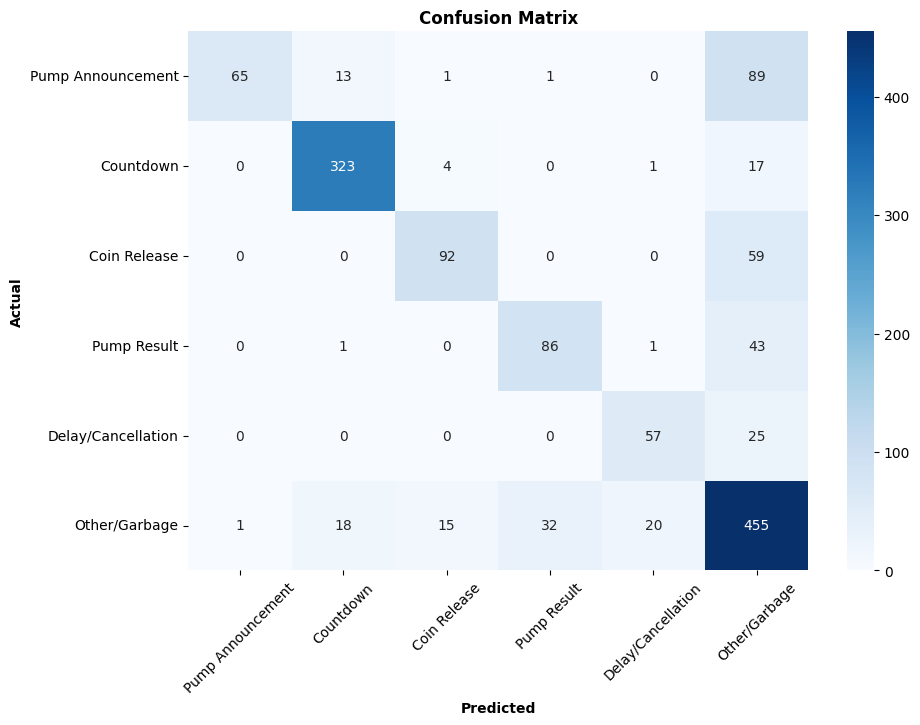

In [17]:
test_df['prediction'] = test_df['message'].apply(heuristic_classification)

overall_accuracy = accuracy_score(test_df['label'], test_df['prediction'])
print(f'Overall accuracy: {overall_accuracy:.4f}')

categories = ['Pump Announcement', 'Countdown', 'Coin Release', 'Pump Result', 'Delay/Cancellation', 'Other/Garbage']
print('\nClassification Report Test:')
print(classification_report(test_df['label'], test_df['prediction'], target_names=categories))

conf_matrix = confusion_matrix(test_df['label'], test_df['prediction'], labels=[0,1,2,3,4,5])

per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for idx, acc in enumerate(per_class_accuracy):
    print(f'Accuracy for class {idx} ({categories[idx]}): {acc:.4f}')

print("\n")
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted', fontweight="bold")
plt.ylabel('Actual', fontweight="bold")
plt.title('Confusion Matrix', fontweight="bold")
plt.xticks(rotation=45)
plt.show()